In [8]:
!pip install networkx scipy


python(31477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [1]:
import numpy as np
import scipy.io as sio
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
base = "/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/raw/"

files = {"DK68": base + "DTI_fiber_consensus_HCP_68.mat", "Schaefer100": base + "Schaefer100_HCP_DTI_count.mat", "Schaefer200": base + "Schaefer200_HCP_DTI_count.mat",}

files



{'DK68': '/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/raw/DTI_fiber_consensus_HCP_68.mat',
 'Schaefer100': '/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/raw/Schaefer100_HCP_DTI_count.mat',
 'Schaefer200': '/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/raw/Schaefer200_HCP_DTI_count.mat'}

In [3]:
def load_sc_from_mat(path, var_name=None):
    """
    Load a structural connectivity matrix from a MATLAB .mat file.

    If var_name is None, it will take the first 2D array it finds.
    """
    mat = sio.loadmat(path)
    if var_name is not None:
        W = mat[var_name]
    else:
        # auto-detect first 2D numeric array
        candidate = None
        for k, v in mat.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and v.ndim == 2:
                candidate = v
                break
        if candidate is None:
            raise ValueError("No 2D array found in .mat file. Provide var_name explicitly.")
        W = candidate

    W = np.array(W, dtype=float)
    # symmetrize and zero diagonal
    W = 0.5 * (W + W.T)
    np.fill_diagonal(W, 0.0)
    return W


In [4]:
W_dk = load_sc_from_mat(files["DK68"])
W_100 = load_sc_from_mat(files["Schaefer100"])
W_200 = load_sc_from_mat(files["Schaefer200"])

W_dk.shape, W_100.shape, W_200.shape


((68, 68), (100, 100), (200, 200))

In [5]:
def sc_to_graph(W, threshold=0.0):
    """
    Convert a weight matrix to a NetworkX graph.
    Edges with |w| <= threshold are ignored.
    """
    N = W.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(N))
    rows, cols = np.where(np.abs(W) > threshold)
    for i, j in zip(rows, cols):
        if i < j:
            G.add_edge(int(i), int(j), weight=float(W[i, j]))
    return G


In [6]:
def compute_sc_metrics(W):
    """
    Compute:
    - N
    - density
    - mean degree
    - mean strength (+ std)
    - Laplacian eigenvalues
    - lambda2, lambdamax, spectral spread
    """
    N = W.shape[0]
    G = sc_to_graph(W, threshold=0.0)

    density = nx.density(G)
    degrees = np.array([d for _, d in G.degree()])
    strengths = np.array([
        sum(d['weight'] for _, _, d in G.edges(n, data=True))
        for n in G.nodes()
    ])

    mean_degree = degrees.mean()
    mean_strength = strengths.mean()
    std_strength = strengths.std()

    # weighted Laplacian
    L = nx.laplacian_matrix(G, weight='weight').astype(float).toarray()
    eigvals = np.linalg.eigvalsh(L)
    eigvals = np.sort(eigvals)

    lambda2 = eigvals[1] if len(eigvals) >= 2 else np.nan
    lambdamax = eigvals[-1]
    spectral_spread = lambdamax / lambda2 if lambda2 > 0 else np.nan

    return {
        "N": N,
        "density": density,
        "mean_degree": mean_degree,
        "mean_strength": mean_strength,
        "std_strength": std_strength,
        "lambda2": lambda2,
        "lambdamax": lambdamax,
        "spectral_spread": spectral_spread,
        "eigvals": eigvals,
    }


In [7]:
for name, W in [("DK68", W_dk), ("Sch100", W_100), ("Sch200", W_200)]:
    m = compute_sc_metrics(W)
    print(f"\n{name} metrics:")
    for k, v in m.items():
        if k == "eigvals":
            continue
        print(f"  {k}: {v}")



DK68 metrics:
  N: 68
  density: 0.27480245829675154
  mean_degree: 18.41176470588235
  mean_strength: 8499.213226520305
  std_strength: 6538.440928712251
  lambda2: 840.5801828345999
  lambdamax: 33668.58750419918
  spectral_spread: 40.053986748369624

Sch100 metrics:
  N: 100
  density: 0.15373737373737373
  mean_degree: 15.22
  mean_strength: 4955.26
  std_strength: 3718.999474643684
  lambda2: 406.8524289312607
  lambdamax: 20671.65562649223
  spectral_spread: 50.80873102022155

Sch200 metrics:
  N: 200
  density: 0.07698492462311558
  mean_degree: 15.32
  mean_strength: 2637.76
  std_strength: 2349.7095442628647
  lambda2: 96.55772041301441
  lambdamax: 16699.238103077994
  spectral_spread: 172.94565397410946


In [8]:
def louvain_communities_and_modularity(W):
    """
    Run Louvain community detection and compute modularity Q.
    """
    G = sc_to_graph(W, threshold=0.0)

    # NetworkX Louvain (available in recent versions)
    communities = list(nx.algorithms.community.louvain_communities(G, weight='weight'))

    Q = nx.algorithms.community.quality.modularity(G, communities, weight='weight')
    return communities, Q


In [9]:
for name, W in [("DK68", W_dk), ("Sch100", W_100), ("Sch200", W_200)]:
    comms, Q = louvain_communities_and_modularity(W)
    sizes = [len(c) for c in comms]
    print(f"\n{name}:")
    print(f"  # communities: {len(comms)}")
    print(f"  community sizes: {sizes}")
    print(f"  modularity Q: {Q:.3f}")



DK68:
  # communities: 4
  community sizes: [12, 21, 21, 14]
  modularity Q: 0.371

Sch100:
  # communities: 6
  community sizes: [18, 9, 15, 21, 17, 20]
  modularity Q: 0.514

Sch200:
  # communities: 7
  community sizes: [34, 22, 44, 10, 37, 44, 9]
  modularity Q: 0.584


In [10]:
def plot_adjacency(W, title="Adjacency matrix"):
    plt.figure(figsize=(4, 4))
    im = plt.imshow(W, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Weight')
    plt.title(title)
    plt.xlabel("Node")
    plt.ylabel("Node")
    plt.tight_layout()
    plt.show()


In [11]:
def plot_adjacency_by_communities(W, communities, title="Adjacency (sorted by community)"):
    order = [node for comm in communities for node in sorted(comm)]
    W_sorted = W[np.ix_(order, order)]

    plt.figure(figsize=(4, 4))
    im = plt.imshow(W_sorted, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Weight')
    plt.title(title)
    plt.xlabel("Node (sorted)")
    plt.ylabel("Node (sorted)")
    plt.tight_layout()
    plt.show()


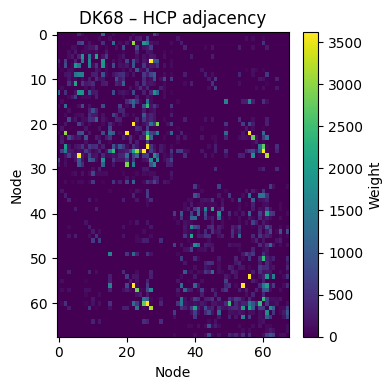

In [12]:
plot_adjacency(W_dk, title="DK68 – HCP adjacency")


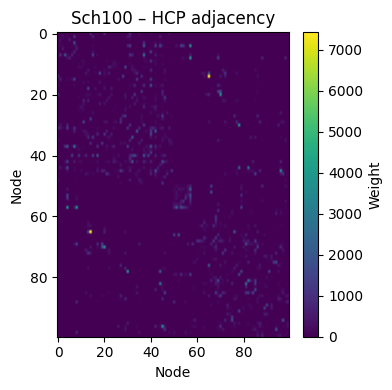

In [13]:
plot_adjacency(W_100, title="Sch100 – HCP adjacency")


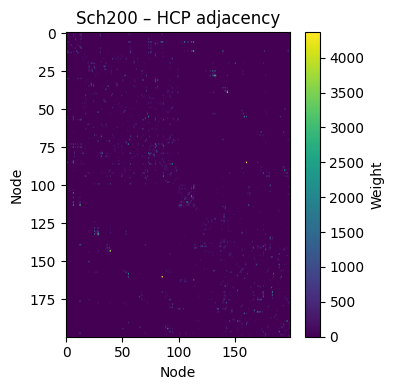

In [14]:
plot_adjacency(W_200, title="Sch200 – HCP adjacency")

In [15]:
def plot_adjacency_by_communities(W, communities, title="Adjacency (sorted by community)"):
    order = [node for comm in communities for node in sorted(comm)]
    W_sorted = W[np.ix_(order, order)]

    plt.figure(figsize=(4, 4))
    im = plt.imshow(W_sorted, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Weight')
    plt.title(title)
    plt.xlabel("Node (sorted)")
    plt.ylabel("Node (sorted)")
    plt.tight_layout()
    plt.show()


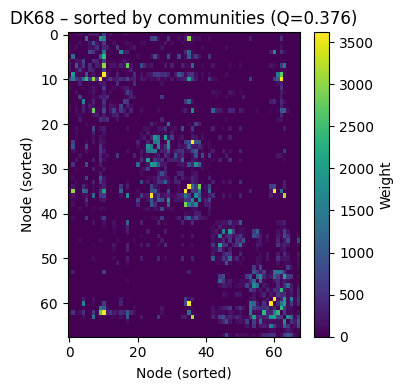

In [16]:
comms_dk, Q_dk = louvain_communities_and_modularity(W_dk)
plot_adjacency_by_communities(W_dk, comms_dk, title=f"DK68 – sorted by communities (Q={Q_dk:.3f})")


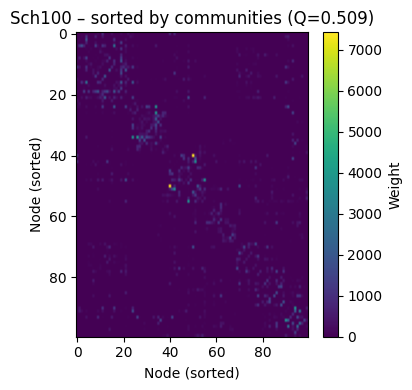

In [17]:
comms_100, Q_100 = louvain_communities_and_modularity(W_100)
plot_adjacency_by_communities(W_100, comms_100, title=f"Sch100 – sorted by communities (Q={Q_100:.3f})")

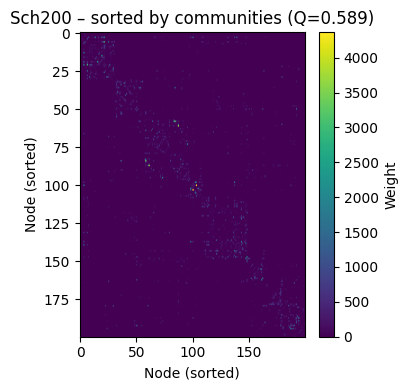

In [18]:
comms_200, Q_200 = louvain_communities_and_modularity(W_200)
plot_adjacency_by_communities(W_200, comms_200, title=f"Sch200 – sorted by communities (Q={Q_200:.3f})")

In [19]:
def plot_laplacian_spectrum(eigvals, title="Laplacian eigenvalues"):
    plt.figure(figsize=(5, 3))
    plt.plot(eigvals, marker='o', linestyle='-')
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue")
    plt.title(title)
    plt.tight_layout()
    plt.show()


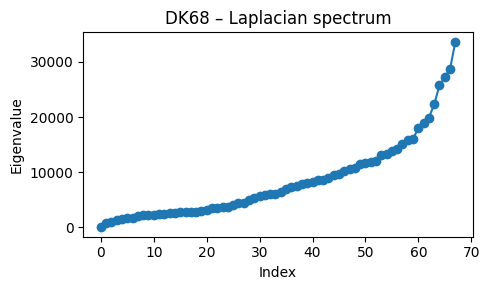

In [20]:
metrics_dk = compute_sc_metrics(W_dk)
plot_laplacian_spectrum(metrics_dk["eigvals"], title="DK68 – Laplacian spectrum")

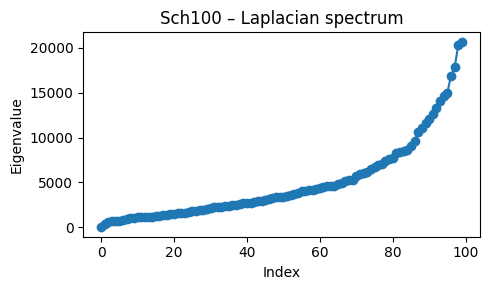

In [21]:
metrics_100 = compute_sc_metrics(W_100)
plot_laplacian_spectrum(metrics_100["eigvals"], title="Sch100 – Laplacian spectrum")

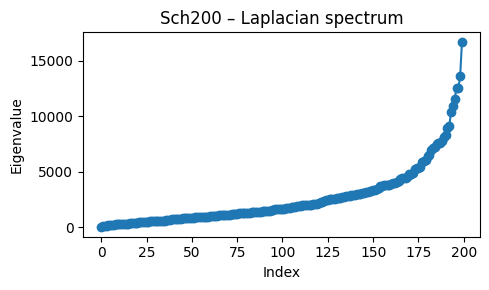

In [22]:
metrics_200 = compute_sc_metrics(W_200)
plot_laplacian_spectrum(metrics_200["eigvals"], title="Sch200 – Laplacian spectrum")

In [23]:
def generate_synthetic_sc_like(W_ref, seed=0):
    """
    Generate a synthetic SC that roughly matches:
    - #nodes
    - modular structure
    - mean edge weight per module-pair
    """
    rng = np.random.default_rng(seed)
    N = W_ref.shape[0]

    # 1) Louvain on reference
    communities_ref, Q_ref = louvain_communities_and_modularity(W_ref)
    node2comm = {}
    for ci, comm in enumerate(communities_ref):
        for n in comm:
            node2comm[n] = ci

    C = len(communities_ref)
    sizes = np.array([len(c) for c in communities_ref])

    # 2) Estimate probability and mean abs(weight) between modules
    p_ab = np.zeros((C, C))
    mu_ab = np.zeros((C, C))

    for i in range(N):
        for j in range(i + 1, N):
            a = node2comm[i]
            b = node2comm[j]
            w = W_ref[i, j]
            if w != 0:
                p_ab[a, b] += 1
                p_ab[b, a] += 1
                mu_ab[a, b] += np.abs(w)
                mu_ab[b, a] += np.abs(w)

    for a in range(C):
        for b in range(C):
            if a <= b:
                if a == b:
                    n_pairs = sizes[a] * (sizes[a] - 1) / 2
                else:
                    n_pairs = sizes[a] * sizes[b]
                if n_pairs > 0:
                    p_ab[a, b] = p_ab[b, a] = p_ab[a, b] / n_pairs
                    if p_ab[a, b] > 0:
                        mu_ab[a, b] = mu_ab[b, a] = mu_ab[a, b] / p_ab[a, b]
                    else:
                        mu_ab[a, b] = mu_ab[b, a] = 0.0

    # 3) Sample new SC
    W_syn = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            a = node2comm[i]
            b = node2comm[j]
            prob = p_ab[a, b]
            if prob <= 0:
                continue
            if rng.random() < prob:
                mu = mu_ab[a, b]
                scale = mu if mu > 0 else 1.0
                # sample positive weight lognormally
                w = rng.lognormal(mean=np.log(scale + 1e-6), sigma=0.25)
                W_syn[i, j] = W_syn[j, i] = w

    np.fill_diagonal(W_syn, 0.0)

    scale_factor = np.max(np.abs(W_ref)) / np.max(np.abs(W_syn))
    W_syn = W_syn * scale_factor
    return W_syn, communities_ref, Q_ref


Synthetic DK-like SC metrics:
  N: 68
  density: 0.4183494293239684
  mean_degree: 28.029411764705884
  mean_strength: 35740.9193557597
  std_strength: 7459.711409877322
  lambda2: 11297.45458511688
  lambdamax: 57507.4086051096
  spectral_spread: 5.090297834068668


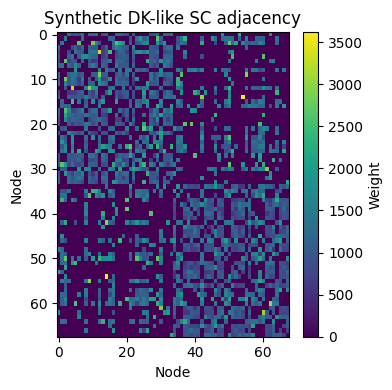

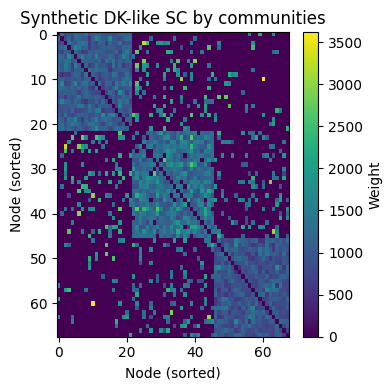

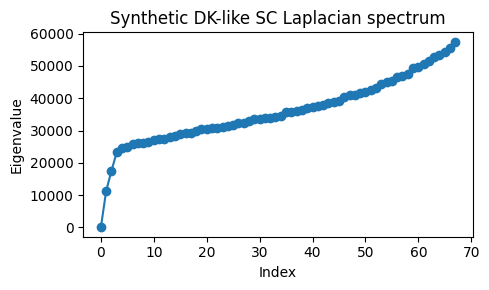

In [24]:
W_syn_dk, comms_ref, Q_ref = generate_synthetic_sc_like(W_dk, seed=42)

metrics_syn = compute_sc_metrics(W_syn_dk)
print("Synthetic DK-like SC metrics:")
for k, v in metrics_syn.items():
    if k == "eigvals":
        continue
    print(f"  {k}: {v}")

plot_adjacency(W_syn_dk, title="Synthetic DK-like SC adjacency")
plot_adjacency_by_communities(W_syn_dk, comms_ref, title="Synthetic DK-like SC by communities")
plot_laplacian_spectrum(metrics_syn["eigvals"], title="Synthetic DK-like SC Laplacian spectrum")


In [25]:
# W_dk      = original DK68 SC
# W_syn_dk  = synthetic DK-like SC
# compute_sc_metrics(...) defined before

metrics_dk    = compute_sc_metrics(W_dk)
metrics_syn_dk = compute_sc_metrics(W_syn_dk)

print("Original DK68 metrics:")
for k, v in metrics_dk.items():
    if k == "eigvals":
        continue
    print(f"  {k}: {v}")

print("\nSynthetic DK-like metrics:")
for k, v in metrics_syn_dk.items():
    if k == "eigvals":
        continue
    print(f"  {k}: {v}")


Original DK68 metrics:
  N: 68
  density: 0.27480245829675154
  mean_degree: 18.41176470588235
  mean_strength: 8499.213226520305
  std_strength: 6538.440928712251
  lambda2: 840.5801828345999
  lambdamax: 33668.58750419918
  spectral_spread: 40.053986748369624

Synthetic DK-like metrics:
  N: 68
  density: 0.4183494293239684
  mean_degree: 28.029411764705884
  mean_strength: 35740.9193557597
  std_strength: 7459.711409877322
  lambda2: 11297.45458511688
  lambdamax: 57507.4086051096
  spectral_spread: 5.090297834068668


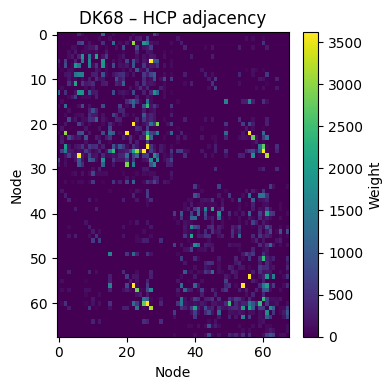

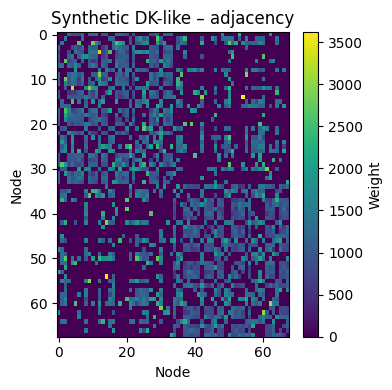

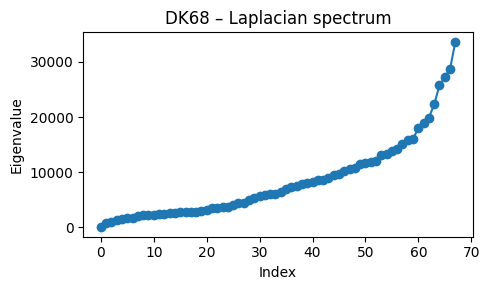

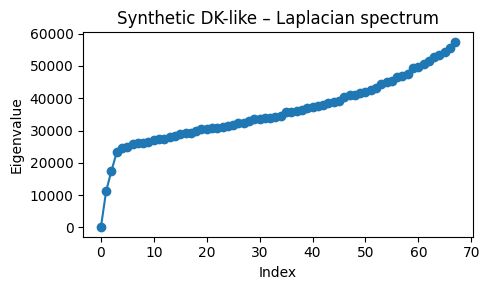

In [26]:
plot_adjacency(W_dk,     title="DK68 – HCP adjacency")
plot_adjacency(W_syn_dk, title="Synthetic DK-like – adjacency")

plot_laplacian_spectrum(metrics_dk["eigvals"],     title="DK68 – Laplacian spectrum")
plot_laplacian_spectrum(metrics_syn_dk["eigvals"], title="Synthetic DK-like – Laplacian spectrum")


In [27]:
## DK68 Variants for Topology-Control Experiments 

rng = np.random.default_rng(42)

def add_random_edges(W, frac_edges=0.02, scale=0.5):
    """
    Slightly increase integration: add or strengthen a small fraction of edges.
    """
    W_new = W.copy()
    N = W.shape[0]
    pairs = [(i, j) for i in range(N) for j in range(i+1, N)]
    rng.shuffle(pairs)

    n = int(frac_edges * len(pairs))
    nonzero = W[np.triu_indices(N, k=1)]
    med = np.median(nonzero[nonzero > 0])

    for (i, j) in pairs[:n]:
        if W_new[i, j] == 0:
            W_new[i, j] = W_new[j, i] = scale * med
        else:
            W_new[i, j] *= (1 + 0.2 * scale)
            W_new[j, i] = W_new[i, j]

    np.fill_diagonal(W_new, 0.0)
    return W_new


def prune_random_edges(W, frac_edges=0.05):
    """
    Reduce density by pruning a fraction of the weakest edges.
    """
    W_new = W.copy()
    N = W.shape[0]
    iu = np.triu_indices(N, k=1)
    vals = W_new[iu]
    nonzero_vals = vals[vals > 0]

    n_prune = int(frac_edges * nonzero_vals.size)
    if n_prune == 0:
        return W_new

    # threshold at the n_prune-th smallest non-zero weight
    thresh = np.partition(nonzero_vals, n_prune - 1)[n_prune - 1]
    mask = (W_new <= thresh) & (W_new > 0)
    mask = np.triu(mask, k=1)
    W_new[mask] = 0.0
    W_new[mask.T] = 0.0

    np.fill_diagonal(W_new, 0.0)
    return W_new


def random_rewire_preserve_weights(W, frac_rewire=0.05):
    """
    Rewire a fraction of edges while preserving the set of weights.
    """
    W_new = W.copy()
    N = W.shape[0]
    iu = np.triu_indices(N, k=1)
    weights = W_new[iu]
    nz_idx = np.where(weights > 0)[0]

    n_rewire = int(frac_rewire * nz_idx.size)
    if n_rewire == 0:
        return W_new

    # pick edges to remove
    remove_idx = rng.choice(nz_idx, size=n_rewire, replace=False)
    removed_weights = []
    for idx in remove_idx:
        i, j = iu[0][idx], iu[1][idx]
        removed_weights.append(W_new[i, j])
        W_new[i, j] = W_new[j, i] = 0.0

    # place them on random non-edges
    zero_pairs = [(i, j) for i in range(N) for j in range(i+1, N) if W_new[i, j] == 0]
    rng.shuffle(zero_pairs)

    for w, (i, j) in zip(removed_weights, zero_pairs):
        W_new[i, j] = W_new[j, i] = w

    np.fill_diagonal(W_new, 0.0)
    return W_new



In [28]:
# Variants of the empirical DK68 SC
W_dk_A = add_random_edges(W_dk, frac_edges=0.02, scale=0.5)      # ↑ integration (↑ lambda2)
W_dk_B = prune_random_edges(W_dk, frac_edges=0.05)               # ↓ density
W_dk_C = random_rewire_preserve_weights(W_dk, frac_rewire=0.03)  # same weights, diff topology



In [29]:
metrics_A = compute_sc_metrics(W_dk_A)
metrics_B = compute_sc_metrics(W_dk_B)
metrics_C = compute_sc_metrics(W_dk_C)

import pandas as pd

df_dk_variants = pd.DataFrame.from_dict(
    {
        "DK68_empirical": metrics_dk,
        "DK68_var_A":     metrics_A,
        "DK68_var_B":     metrics_B,
        "DK68_var_C":     metrics_C,
    },
    orient="index",
)
df_dk_variants


,N,density,mean_degree,mean_strength,std_strength,lambda2,lambdamax,spectral_spread,eigvals
DK68_empirical,68,0.274802,18.411765,8499.213227,6538.440929,840.580183,33668.587504,40.053987,"[-5.684660259992198e-14, 840.5801828345999, 98..."
DK68_var_A,68,0.287533,19.264706,8631.338289,6556.994124,846.901644,33810.047655,39.922047,"[-3.5349511932326136e-12, 846.9016442805303, 1..."
DK68_var_B,68,0.261194,17.500000,8439.871611,6528.620050,836.995660,33539.250885,40.070997,"[5.052180895855092e-12, 836.9956595149313, 933..."
DK68_var_C,68,0.274802,18.411765,8499.213227,6377.965162,1126.899533,32981.326959,29.267318,"[-1.5032441437468073e-12, 1126.899533338028, 1..."


In [30]:
import numpy as np

np.save("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_syn_DK68.npy", W_syn_dk)


In [31]:
np.save("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_DK68_variant_A.npy", W_dk_A)
np.save("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_DK68_variant_B.npy", W_dk_B)
np.save("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_DK68_variant_C.npy", W_dk_C)


In [32]:
import os
os.makedirs("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed", exist_ok=True)

np.save("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_DK68_empirical.npy",  W_dk)
np.save("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_Sch100_empirical.npy", W_100)
np.save("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_Sch200_empirical.npy", W_200)
